## Part 1: Pulse Rate Algorithm

### Contents
Fill out this notebook as part of your final project submission.

**You will have to complete both the Code and Project Write-up sections.**
- The [Code](#Code) is where you will write a **pulse rate algorithm** and already includes the starter code.
   - Imports - These are the imports needed for Part 1 of the final project. 
     - [glob](https://docs.python.org/3/library/glob.html)
     - [numpy](https://numpy.org/)
     - [scipy](https://www.scipy.org/)
- The [Project Write-up](#Project-Write-up) to describe why you wrote the algorithm for the specific case.


### Dataset
You will be using the **Troika**[1] dataset to build your algorithm. Find the dataset under `datasets/troika/training_data`. The `README` in that folder will tell you how to interpret the data. The starter code contains a function to help load these files.

1. Zhilin Zhang, Zhouyue Pi, Benyuan Liu, ‘‘TROIKA: A General Framework for Heart Rate Monitoring Using Wrist-Type Photoplethysmographic Signals During Intensive Physical Exercise,’’IEEE Trans. on Biomedical Engineering, vol. 62, no. 2, pp. 522-531, February 2015. Link

-----

### Code

In [6]:
import glob

import numpy as np
import scipy as sp
import scipy.io
import glob
import scipy.stats
import scipy.signal
import os
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold

# Define global frequency domain parameters
Fs = 125            # the sampling frequency
fmin = 40/60        # [Hz]
fmax = 240/60       # [Hz] 

model = None

def LoadTroikaDataset():
    """
    Retrieve the .mat filenames for the troika dataset.

    Review the README in ./datasets/troika/ to understand the organization of the .mat files.

    Returns:
        data_fls: Names of the .mat files that contain signal data
        ref_fls: Names of the .mat files that contain reference data
        <data_fls> and <ref_fls> are ordered correspondingly, so that ref_fls[5] is the 
            reference data for data_fls[5], etc...
    """
    data_dir = "./datasets/troika/training_data"
    data_fls = sorted(glob.glob(data_dir + "/DATA_*.mat"))
    ref_fls = sorted(glob.glob(data_dir + "/REF_*.mat"))
    return data_fls, ref_fls

def LoadTroikaDataFile(data_fl):
    """
    Loads and extracts signals from a troika data file.

    Usage:
        data_fls, ref_fls = LoadTroikaDataset()
        ppg, accx, accy, accz = LoadTroikaDataFile(data_fls[0])

    Args:
        data_fl: (str) filepath to a troika .mat file.

    Returns:
        numpy arrays for ppg, accx, accy, accz signals.
    """
    data = sp.io.loadmat(data_fl)['sig']
    return data[2:]



def LoadRefDataFile(ref_fl):
    """
    Loads and extracts signals from a troika data file.

    Usage:
        data_fls, ref_fls = LoadTroikaDataset()
        ppg, accx, accy, accz = LoadRefDataFile(data_fls[0])

    Args:
        data_fl: (str) filepath to a troika .mat file.

    Returns:
        numpy arrays for ppg, accx, accy, accz signals.
    """
     # load the reference signal
   
    data = sp.io.loadmat(ref_fl)['BPM0']
    return data.reshape(-1)

def AggregateErrorMetric(pr_errors, confidence_est):
    """
    Computes an aggregate error metric based on confidence estimates.

    Computes the MAE at 90% availability. 

    Args:
        pr_errors: a numpy array of errors between pulse rate estimates and corresponding 
            reference heart rates.
        confidence_est: a numpy array of confidence estimates for each pulse rate
            error.

    Returns:
        the MAE at 90% availability
    """
    # Higher confidence means a better estimate. The best 90% of the estimates
    #    are above the 10th percentile confidence.
    percentile90_confidence = np.percentile(confidence_est, 10)

    # Find the errors of the best pulse rate estimates
    best_estimates = pr_errors[confidence_est >= percentile90_confidence]

    # Return the mean absolute error
    return np.mean(np.abs(best_estimates))


def Evaluate():
    """
    Top-level function evaluation function.

    Runs the pulse rate algorithm on the Troika dataset and returns an aggregate error metric.

    Returns:
        Pulse rate error on the Troika dataset. See AggregateErrorMetric.
    """

    global model
    if model is None:
        # Train the model
        model = Train()
    
    # Retrieve dataset files
    data_fls, ref_fls = LoadTroikaDataset()
    errs, confs = [], []
    for data_fl, ref_fl in zip(data_fls, ref_fls):
        # Run the pulse rate algorithm on each trial in the dataset
        errors, confidence = RunPulseRateAlgorithm(data_fl, ref_fl)
        errs.append(errors)
        confs.append(confidence)
        # Compute aggregate error metric
    errs = np.hstack(errs)
    confs = np.hstack(confs)
    return AggregateErrorMetric(errs, confs)

def LoadTrainingDataset():
    """
    Top-level function evaluation function.

    Runs the pulse rate algorithm on the Troika dataset and returns an aggregate error metric.

    Returns: targets and features
    
    """
    # Retrieve dataset files
    data_fls, ref_fls = LoadTroikaDataset()
    targets, features = [], []
    for data_fl, ref_fl in (zip(data_fls, ref_fls)):
        
        # Load data using LoadTroikaDataFile
        ppg, accx, accy, accz = LoadTroikaDataFile(data_fl)
       
        # Load Ground Truth
        bpm0 = LoadRefDataFile(ref_fl)

        start, end = GetSigIntervals(max(len(ppg),len(bpm0)),Fs=125)
    
        for i, s in enumerate(start):
            e = end[i]
        
            # Bandpass filtering the signals
            ppg_bpf  = BPF(ppg[s:e])
            accx_bpf = BPF(accx[s:e])
            accy_bpf = BPF(accy[s:e])
            accz_bpf = BPF(accz[s:e])

            # Get features
            feature = Featurize(ppg_bpf,accx_bpf,accy_bpf,accz_bpf)

            targets.append(bpm0[i])
            features.append(feature)
            
    targets = np.array(targets)
    features = np.array(features)
    return targets, features


def RunPulseRateAlgorithm(data_fl, ref_fl):
    """ Calculates mean absolute errors and confidences
    
    Args:
        data_fl: (string) Path to the signal file
        ref_fl: (string) Path to the reference signal file
        
    Returns:
        (np.array) Mean absolute errors
        (np.array) Confidences
        
    Algorithm steps:
      * The signal is split into equal non-overlapping time-intervals, synchronising the sensor signals and the reference signal.
      * Perform band-pass filtering on the signals to limit the pulse rate range to 40-240 bpm.
      * Extract the frequency domain features: highest-peak frequencies and the energies of those frequencies for each of the four sensor signals (PPG and 3-axes accelerometers).
      * A model is built and trained based on Random Forest Regression that takes the frequency features and predicts the pulse rate.
      * Compute the confidence in the prediction by measuring the approximate pulse energy (integration around the spectral peak).
      * The mean absolute error is used as a metric to evaluate the performance of the model.
      * The algorithm produces a pulse rate estimate and a confidence value at least every 2 seconds.
    """
    # Load data using LoadTroikaDataFile
    ppg, accx, accy, accz = LoadTroikaDataFile(data_fl)
    
    # Load Ground Truth
    bpm0 = LoadRefDataFile(ref_fl)
    #print('Ground truth dimensions: ' + str(len(bpm0)))
    #REF_01_TYPE01
    
    out1 = []
    out2 = []
    
    # If model has not been trained, we will just collect data: (out1,out2)=(targets,features)
    # If model has been trained, use it to predit bpm and give: (out1,out2)=(mae,confidence)
  
    #start_indices, end_indices = get_start_end(len(accx), len(bpm0))
    start, end = GetSigIntervals(max(len(ppg),len(bpm0)),Fs)
    
    for i, s in enumerate(start):
        e = end[i]
        
        # Bandpass filtering the signals
        ppg_bpf  =  BPF(ppg[s:e])
        accx_bpf = BPF(accx[s:e])
        accy_bpf = BPF(accy[s:e])
        accz_bpf = BPF(accz[s:e])

        # Get features
        feature = Featurize(ppg_bpf,accx_bpf,accy_bpf,accz_bpf)

        # Get prediction
        bpm = model.predict(np.reshape(feature, (1, -1)))[0]
        
        # Compute the FFT
        freq, fft_mag = ComputeFourierTransform(ppg_bpf,Fs)

        # Compute the confidence
        freq_est = bpm/60
        conf = GetConfidenceMax(freq,fft_mag,freq_est)

        out1.append(np.abs(bpm - bpm0[i]))
        out2.append(conf)
    
    out1 = np.array(out1)
    out2 = np.array(out2)
    # Return mean absolute error and confidence as a 2-tuple of numpy arrays.
    return out1, out2

def BPF(signal, fmin=40/60, fmax=240/60, fs=125):
    """Bandpass filter the signal between 0.67 and 4 Hz."""
    b, a = sp.signal.butter(3, (fmin, fmax), btype='bandpass', fs=fs)
    return sp.signal.filtfilt(b, a, signal)

def GetConfidenceMax(freq,fft_mag,freq_est,n_samples=6):
    """
    Get the confidence value for a particular frequency.
    Integrates the power spectrum around that frequency and normalizes it to the total power
    """  
    tot_power = sum(fft_mag)
    p = (np.abs(freq - freq_est)).argmin()
    confidence = np.sum(fft_mag[p - n_samples: p + n_samples])/tot_power
    return confidence

def GetSigIntervals(N,Fs=125,window_length_s = 10,window_shift_s = 2):
    """
    Define the window intervals in time domain.
    """
    
    window_length = window_length_s * Fs
    window_shift = window_shift_s * Fs
    start = []
    end = []
    for i in range(0, N - window_length + window_shift, window_shift):
        #window = ppg[i: i + window_length]
        start.append(i)
        end.append(i+window_length)
    
    return (start, end)

def ComputeFourierTransform(sig,Fs):
    """
    Get the frequency components and signal spectrum, when sampling at Fs.
    """
    freq = np.fft.rfftfreq(len(sig),1/Fs)
    fft_mag = np.abs(np.fft.rfft(sig))
    return freq, fft_mag 


def Train():
    """
    Define and train a RandomForest model to predit the pulse rate from the frequency features of the measured signals.
    """
    model = RandomForestRegressor(n_estimators=100,max_depth=15)
    
    lf = KFold(n_splits=5)
    targets, features = LoadTrainingDataset()
    splits = lf.split(features,targets)
    
    for i, (train_idx, test_idx) in enumerate(splits):
        X_train, y_train = features[train_idx], targets[train_idx]
        X_test, y_test = features[test_idx], targets[test_idx]
        model.fit(X_train, y_train)
    
    return model
    

def Featurize(ppg, accx, accy, accz, Fs=125):
    """ Create features """
    
    verbose = False
    
    freq_p, mag_p, conf_p = GetPeakFreq(BPF(ppg), Fs,verbose)
    freq_x, mag_x, conf_x = GetPeakFreq(BPF(accx),Fs,verbose)
    freq_y, mag_y, conf_y = GetPeakFreq(BPF(accy),Fs,verbose)
    freq_z, mag_z, conf_z = GetPeakFreq(BPF(accz),Fs,verbose)

    return [freq_p[0], freq_x[0], freq_y[0], freq_z[0], \
            conf_p[0], conf_x[0], conf_y[0], conf_z[0] ]

def GetPeakFreq(sig,Fs,verbose=False):
    """ Get frequencies and their energies in order of their spectral magnitude """
    # Compute the FFT
    freq, fft_mag = ComputeFourierTransform(sig,Fs)

    # Compute frequency domain features
    
    # Single max-peak search
    # peaks  = np.max(fft_mag)
    # freq_peaks = freq[np.argmax(fft_mag)]
    
    # Get the peaks in descending order and their indices
    zipped = sorted(zip(fft_mag,freq), key = lambda x: x[0], reverse=True)
    
    # Using list comprehension to perform Unzipping
    unzipped_list = [[ i for i, j in zipped ],[ j for i, j in zipped ]]
    peaks = unzipped_list[0]
    freq_peaks = unzipped_list[1]
    
    # Search and reduce number of peaks we're going to look at (first 10 for instance)
    min_df = 4*(freq[1]-freq[0])
    peaks_selected = [peaks[0]]
    freq_peaks_selected = [freq_peaks[0]]
    n = 1
    while len(peaks_selected)<10:
        l = [abs(freq_peaks[n]-f) for f in freq_peaks_selected]
        if all([d > min_df  for d in l]):
            peaks_selected.append(peaks[n])
            freq_peaks_selected.append(freq_peaks[n])
        n = n+1
    
    peaks = peaks_selected
    freq_peaks = freq_peaks_selected
    
    if verbose:
        plt.plot(freq,fft_mag)
        plt.plot(freq_peaks,peaks,'ro')

        #plt.xlim([fmin,fmax])
        plt.xlim([0,4])
        plt.grid('on')
        plt.show()

    
    confidence = GetConfidence(freq,fft_mag,freq_peaks)
    
    return freq_peaks, peaks, confidence


def GetConfidence(freq,fft_mag,freq_peaks,n_samples=6):
    """ 
    For each of the frequencies in peaks measure the confidence as the 
    power within an integration bandwidth (a percentage of the total 
    bandwidth) around those peaks. Normalized by the total signal power.
    """
    #n_samples = int(percentage*len(fft_mag))
    #print('n_samples'+str(n_samples))
    
    # Pad the spectrum in case our peaks are at the edges of the spectrum
    #fft_mag  = [0]*n_samples + fft_mag + [0]*n_samples
    #freq     = [0]*n_samples + freq    + [0]*n_samples
    
    tot_power = sum(fft_mag)

    idx_peaks = [np.where(freq==x)[0][0] for x in freq_peaks]   

    #print('freq[idx_peaks]')
    #print(freq[idx_peaks])
    #print('freq_peaks')
    #print(freq_peaks)

    confidence = []
    for p in idx_peaks:
        confidence.append(np.sum(fft_mag[p - n_samples: p + n_samples])/tot_power)
    
    #p = idx_peaks[0]
    #plt.plot(freq,fft_mag)
    #plt.plot(freq[p - n_samples: p + n_samples],fft_mag[p - n_samples: p + n_samples],'r')
    #plt.xlim([0.6,4])
    #plt.title(freq[p])
    #plt.show()
    
    return confidence

In [7]:
Evaluate()

5.3077255622880424

-----
### Project Write-up

Answer the following prompts to demonstrate understanding of the algorithm you wrote for this specific context.

> - **Code Description** - Include details so someone unfamiliar with your project will know how to run your code and use your algorithm. 
> - **Data Description** - Describe the dataset that was used to train and test the algorithm. Include its short-comings and what data would be required to build a more complete dataset.
> - **Algorithhm Description** will include the following:
>   - how the algorithm works
>   - the specific aspects of the physiology that it takes advantage of
>   - a describtion of the algorithm outputs
>   - caveats on algorithm outputs 
>   - common failure modes
> - **Algorithm Performance** - Detail how performance was computed (eg. using cross-validation or train-test split) and what metrics were optimized for. Include error metrics that would be relevant to users of your algorithm. Caveat your performance numbers by acknowledging how generalizable they may or may not be on different datasets.

Your write-up goes here...

**Code Description.** The code consists of an algorithm that:
  * estimates pulse rate from the PPG signal and a 3-axis accelerometer.
  * assumes pulse rate will be restricted between 40BPM (beats per minute) and 240BPM
  * produces an estimation confidence. A higher confidence value means that this estimate should be more accurate than an estimate with a lower confidence value.
  * produces an output at least every 2 seconds.  
  
  The code consists of multiple functions that are used to read and process the time-domain waveforms, to then extract frequency-domain features (domninant frequencies and their normalized energy) and finally training of a classifier to estiamte the pulse rate.
  
  To run the code:
  Define global parameters (or leave as default):
  
  Fs = 125            # the sampling frequency [Hz]
  
  fmin = 40/60        # low frequency of bandpass filter [Hz]
  
  fmax = 240/60       # high frequency of bandpass filter [Hz] 


  Use Evaluate() to run the code and get an mean absolute error of the  estimate.
    
**Data Description.** 
  
  The input data are: Photoplethysmographic (PPG) signal, three-axis accelerometer signals and an Electro-cardiogram (ECG) signal (the latter being the ground truth). The sampling rate is 125 Hz.
  
  These training features are extracted from the frequency domain reprensentation of the PPG and accelerometer signals: the peak frequencies in each signal and their corresponding approximate energies relative to the total signal energy are nested.
  
  The reference signals given by the ECG.
  
  12 different subjects were monitored while performing alternative running and walking intervals.
  
  Data short-comings: the dataset does not have key demographic details and also does not provide a good coverage on all subjects. If we had information for example of the ages of the subjects, this could have been used as a feature to the model, with possibilities of improvements of the pulse rate monitor.
  
  For more detailed information on the data:
  
  https://ieeexplore.ieee.org/document/6905737
https://arxiv.org/ftp/arxiv/papers/1504/1504.04785.pdf
  

**Algorithm Description.** 

1) How the algorithm works


  * The signal is split into equal non-overlapping time-intervals, synchronising the sensor signals and the reference signal
  * Perform band-pass filtering on the signals to limit the pulse rate range to 40-240 bpm.
  * Extract the frequency domain features: highest-peak frequencies and the energies of those frequencies for each of the four sensor signals (PPG and 3-axes accelerometers).
  * A model is built and trained based on Random Forest Regression that takes the frequency features and predicts the pulse rate.
  * Compute the confidence in the prediction by measuring the approximate pulse energy (integration around the spectral peak).
  * The mean absolute error is used as a metric to evaluate the performance of the model.
  * The algorithm outputs a mean absolute error between the estimations and the ground truth signal and a confidence value at least every 2 seconds.
  
  
2) The specific aspects of the physiology that it takes advantage of

The pulse rate can be monitored from the period changes of reflections from green-light LEDs i.e. when more blood pumps through capilaries less light is reflected back to the device.
 
The sensor used in monitoring the pulse rates of subjects is a PPG with the following technical specifications:
  * The PPG has two channels, of whcih the second is used.
  * The PPG signals were recorded from wrist by two pulse oximeters with green LEDs (wavelength: 515nm). 
  * Their distance (from center to center) was 2 cm.
  
The motions sensors are accelerometeers with the following specifications:
  * Provides three-axis acceleration measurements: X, Y and Z.
  * Embedded into a wristband.
  
The ECG monitor:
  * Wet ECG sensors embedded onto a chest strap.
  * The provide the most accurate measurement of the pulse rate and thus constitute the ground truth.
  
3) Description of the algorithm outputs

The algorithm estimates the pulse rate of the subject and outputs the mean absolute error between the ECG pulse rate (ground truth) and the pulse rate estimated by the algorithm. The second output is the confidence in this estimate.

4) Caveats on algorithm outputs

From an intuitive perspective, the confidence in the estimator is determined as follows: 
  * If our pulse rate estimator is picking a strong frequency component that's not present in the accelerometer, we can be relatively confident in the estimate. 
  * If our pulse rate estimator is picking a frequency that's strong in the accelerometer, it may be making a mistake.
 
5) Common failure modes
 The algorithm is sensitive to the hyperparameters of the model as well as other parameters such as the integration bandwidth to obtain the confidence values, the limited number of samples per interval making it more difficult to accurately estimate the power around the frequencies of interst. 
 The signals differ in lengths between data files.

    
**Algorithm Performance.** 
The algorithm perfors in under 5bpm mean absolute error on the available training data. This error value is very low, thanks to the (manual) tunning of hyperparameters of the model (i.e. model depth, number and type of input features).

On a completely new testing data, the algorithm performs in under 11bpm mean absolute error.

--- END ---

### Experimental code

In [244]:
# Define a bunch of time and frequency domain parameters
dt = 8              # the sampling time interval [s]
NFFT = 1024         # the length of the windowing segments
Fs = 125            # the sampling frequency
fmin = 40/60        # [Hz]
fmax = 240/60       # [Hz] 

Fs

125

In [ ]:
def PlotSpectrogram(x,NFFT,Fs):
    fig, (ax1, ax2) = plt.subplots(nrows=2)
    t = np.arange(len(x)) / Fs
    ax1.plot(t, x)
    Pxx, freqs, bins, im = ax2.specgram(x, NFFT=NFFT, Fs=Fs, noverlap=900)
    # The `specgram` method returns 4 objects. They are:
    # - Pxx: the periodogram
    # - freqs: the frequency vector
    # - bins: the centers of the time bins
    # - im: the .image.AxesImage instance representing the data in the plot
    plt.show()
    return Pxx, freqs, bins, im


74.0
74
592.0
303.496


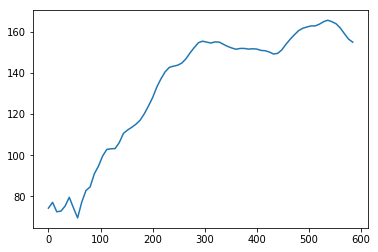

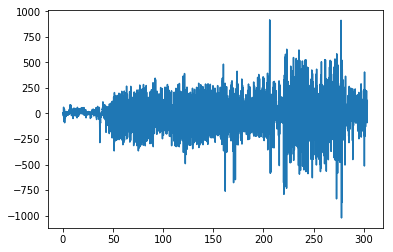

In [245]:
data_fls, ref_fls = LoadTroikaDataset()
ppg, accx, accy, accz = LoadTroikaDataFile(data_fls[0])

bpm0 = LoadRefDataFile(ref_fls[0]).reshape(-1)
print(len(bpm0)/2)
print(len(bpm0[::2]))

t0 = np.arange(0,int(len(bpm0)/2))*8
plt.plot(t0,bpm0[::2])
print(len(bpm0)/2*8)
print(len(ppg)*1/125)

plt.figure()
t = np.arange(0,len(ppg))/Fs
plt.plot(t,ppg)


In [246]:
Fs

125

[ 1.47  2.92  2.96  2.95  1.48  1.46  1.45  2.91  2.9   2.91]


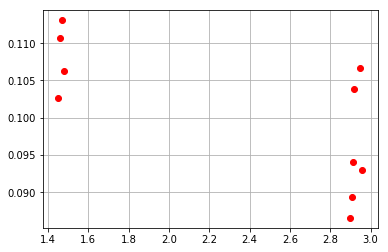

In [274]:
data_fls, ref_fls = LoadTroikaDataset()
ppg, accx, accy, accz = LoadTroikaDataFile(data_fls[0])

sig = accz
bpf_sig = BandpassFilter(sig)
freq, mag, confidence = GetPeakFreq(bpf_sig,Fs)
print(np.round(freq,2))
#print(np.round(mag,2))
#print(confidence)

plt.plot(freq,confidence,'ro')
plt.grid('on')
plt.show()

1054.91655391
19.9203203519


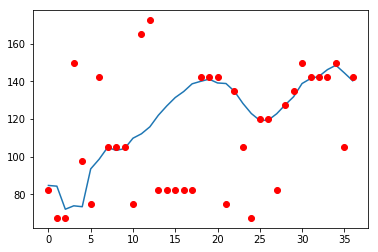

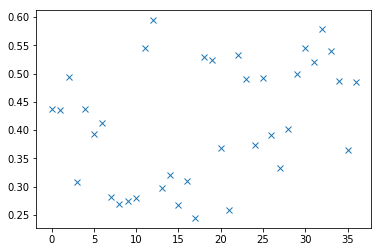

In [285]:
file_no = 1
data_fls, ref_fls = LoadTroikaDataset()
ppg, accx, accy, accz = LoadTroikaDataFile(data_fls[file_no])
bpm0 = LoadRefDataFile(ref_fls[file_no]).reshape(-1)
bpm0 = bpm0[::4] # every 8s, ignore the 6s overlap between consecutive samples
#print('Ground truth dimensions: ' + str(len(bpm0)))

intervals = [8]*int((len(ppg))/Fs/8) #[30,60,60,60,60,30]
ppg, t  = GetSigIntervals(ppg,intervals,Fs)
#for n in range(len(intervals)):
#    plt.plot(t[n],ppg[n])
#plt.show()

accx, t = GetSigIntervals(accx,intervals,Fs)
accy, t = GetSigIntervals(accy,intervals,Fs)
accz, t = GetSigIntervals(accz,intervals,Fs)

bpm = []
conf = []
verbose = False
    
for n in range(len(intervals)):
   
    freq_p, mag_p, conf_p = GetPeakFreq(BandpassFilter(ppg[n]),Fs,verbose)
    freq_x, mag_x, conf_x = GetPeakFreq(BandpassFilter(accx[n]),Fs,verbose)
    freq_y, mag_y, conf_y = GetPeakFreq(BandpassFilter(accy[n]),Fs,verbose)
    freq_z, mag_z, conf_z = GetPeakFreq(BandpassFilter(accz[n]),Fs,verbose)
    
    
    conf_mean_acc = np.mean(np.vstack([conf_x,conf_y,conf_z]),axis=0)
    conf_diff = conf_p - conf_mean_acc

    #max_i = np.argmax(conf_diff)
    
    for n in range(2): # 1=just max peak, 2=second best in case of overlapp with accelerometers
        max_i = np.argmax(mag_p)
        max_f = freq_p[max_i]
        max_p = conf_p[max_i]
        #print(freq_p)

        l = [abs(max_f-f) for f in freq_x+freq_y+freq_z]
        if any([d < 0.01  for d in l]):
            mag_p.pop(max_i)
            freq_p.pop(max_i)
            conf_p.pop(max_i)

        
    #print(max_f)
    bpm.append(max_f*60)
    conf.append(max_p)

#print('Etimated bpm: ' + str(bpm))
    
plt.figure()    
t0 = np.arange(0,len(bpm0))*8
#plt.plot(t0,bpm0)
#plt.plot(np.cumsum(intervals),bpm) 
plt.plot(bpm0)
plt.plot(bpm,'ro') 

errors = bpm0-bpm
print(np.mean(np.square(errors)))
print(AggregateErrorMetric(errors, conf))

plt.figure()
plt.plot(conf,'x')
plt.show()

In [159]:
data_fls, ref_fls = LoadTroikaDataset()
ppg, accx, accy, accz = LoadTroikaDataFile(data_fls[10])
len(ppg)/1000
int((len(ppg))/Fs/8)

36

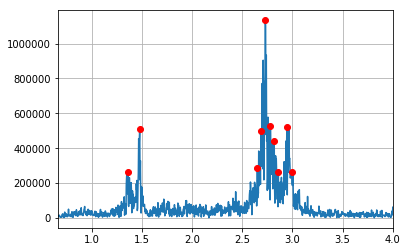

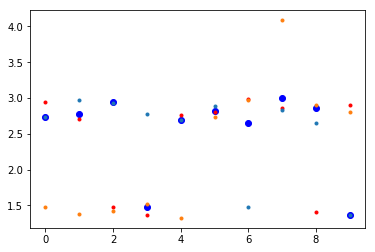

[-0.01221641  0.00155489 -0.13165442 -0.13613973  0.01227501  0.0267987
  0.10563345 -0.04345905  0.02684098 -0.06254444]
6
1.42341249967
bpm = 85.4047499802


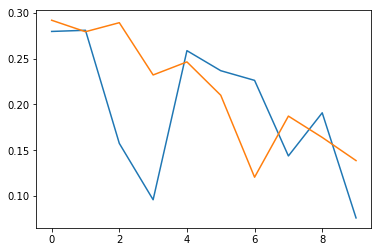

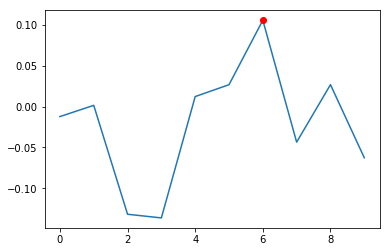

In [60]:
data_fls, ref_fls = LoadTroikaDataset()
ppg, accx, accy, accz = LoadTroikaDataFile(data_fls[10])

freq_p, mag_p, conf_p = GetPeakFreq(BandpassFilter(ppg),Fs,verbose=True)
freq_x, mag_x, conf_x = GetPeakFreq(BandpassFilter(accx),Fs)
freq_y, mag_y, conf_y = GetPeakFreq(BandpassFilter(accy),Fs)
freq_z, mag_z, conf_z = GetPeakFreq(BandpassFilter(accz),Fs)

plt.figure()
plt.plot(freq_p,'bo')
plt.plot(freq_x,'r.')
plt.plot(freq_y,'.')
plt.plot(freq_z,'.')
plt.show()

conf_mean_acc = np.mean(np.vstack([conf_x,conf_y,conf_z]),axis=0)
conf_diff = conf_p - conf_mean_acc


max_i = np.argmax(conf_diff)
max_f = freq[max_i]
bpm = max_f*60
                        
plt.figure()
plt.plot(conf_p)
plt.plot(conf_mean_acc)


print(conf_diff)
print(max_i)
print(max_f)
print('bpm = '+str(max_f*60))

plt.figure()
plt.plot(conf_diff)
plt.plot(max_i,conf_diff[max_i],'ro')


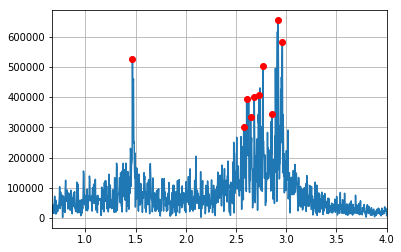

[ 2.92  2.96  1.47  2.77  2.73  2.68  2.61  2.86  2.65  2.58]
[ 0.15  0.14  0.09  0.12  0.12  0.13  0.12  0.15  0.13  0.11]


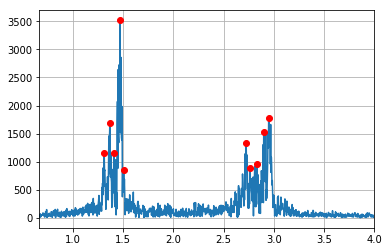

[ 1.47  2.95  1.37  2.9   2.72  1.41  1.31  2.83  2.76  1.51]
[ 0.22  0.17  0.2   0.19  0.13  0.26  0.13  0.15  0.14  0.2 ]


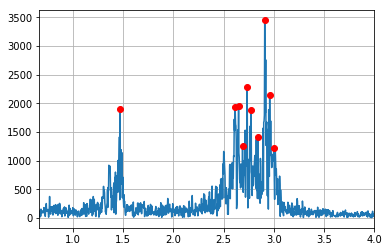

[ 2.91  2.73  2.96  2.65  2.61  1.47  2.77  2.84  2.69  3.  ]
[ 0.21  0.18  0.2   0.18  0.15  0.09  0.17  0.19  0.19  0.18]


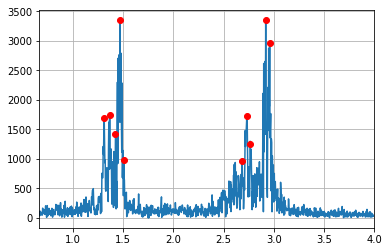

[ 1.47  2.92  2.96  1.37  2.73  1.31  1.42  2.77  1.51  2.69]
[ 0.18  0.21  0.2   0.18  0.13  0.12  0.21  0.14  0.16  0.14]


In [54]:
# Tests
# Evaluate()

verbose = 'True'

data_fls, ref_fls = LoadTroikaDataset()
ppg, accx, accy, accz = LoadTroikaDataFile(data_fls[0])

sig = ppg 
bpf_sig = BandpassFilter(sig)
freq, mag, confidence = GetPeakFreq(bpf_sig,fmin,fmax,Fs,verbose)
print(np.round(freq,2))
#print(np.round(mag,2))
print(np.round(confidence,2))

sig = accx 
bpf_sig = BandpassFilter(sig)
freq, mag, confidence = GetPeakFreq(bpf_sig,fmin,fmax,Fs,verbose)
print(np.round(freq,2))
#print(np.round(mag,2))
print(np.round(confidence,2))

sig = accy 
bpf_sig = BandpassFilter(sig)
freq, mag, confidence = GetPeakFreq(bpf_sig,fmin,fmax,Fs,verbose)
print(np.round(freq,2))
#print(np.round(mag,2))
print(np.round(confidence,2))

sig = accz 
bpf_sig = BandpassFilter(sig)
freq, mag, confidence = GetPeakFreq(bpf_sig,fmin,fmax,Fs,verbose)
print(np.round(freq,2))
#print(np.round(mag,2))
print(np.round(confidence,2))

In [134]:
t=0

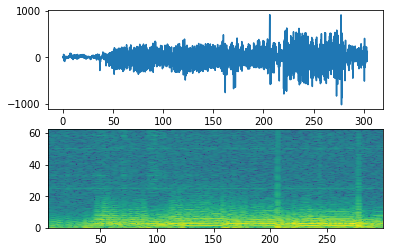

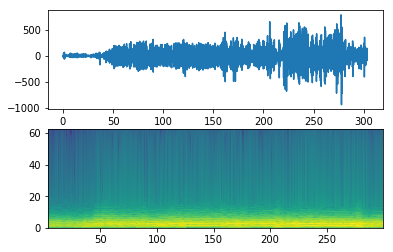

(array([[  5.30620499e-05,   6.57277513e-04,   2.48839129e-04, ...,
           1.37849352e-03,   2.10959389e-03,   1.45528485e-03],
        [  4.24920026e-04,   2.78224589e-03,   5.48302666e-04, ...,
           3.50543553e-03,   1.01784285e-02,   1.43711766e-02],
        [  1.65912330e-03,   7.29680201e-03,   1.02192296e-02, ...,
           3.23060029e-02,   2.44503495e-02,   1.73138138e-01],
        ..., 
        [  4.55032151e-19,   1.01468697e-16,   1.37627415e-16, ...,
           1.19506527e-13,   1.35822719e-14,   2.91278665e-14],
        [  1.39799794e-19,   1.01063988e-16,   1.35824625e-16, ...,
           1.18943516e-13,   1.33315542e-14,   2.89496010e-14],
        [  1.73691339e-20,   5.04645636e-17,   6.76118942e-17, ...,
           5.93779303e-14,   6.62399418e-15,   1.44450917e-14]]),
 array([  0.        ,   0.12207031,   0.24414062,   0.36621094,
          0.48828125,   0.61035156,   0.73242188,   0.85449219,
          0.9765625 ,   1.09863281,   1.22070312,   1.34277344,


In [54]:

# Assumes pulse rate will be restricted between 40BPM (beats per minute) and 240BPM
bpf_ppg = BandpassFilter(ppg, 40/60, 240/60, fs=Fs)

PlotSpectrogram(ppg,NFFT,Fs)
PlotSpectrogram(bpf_ppg,NFFT,Fs)



-----
### Next Steps
You will now go to **Test Your Algorithm** to apply a unit test to confirm that your algorithm met the success criteria. 